<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [4]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import gc
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D, ReLU, BatchNormalization, Dropout, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1 , l2
from tensorflow.keras.metrics import Precision , Recall
from sklearn.model_selection import RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [5]:
DATASET_PATH = './datasets/'
STORED_DATA ='./stored_data/'
def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img) / 255.0 # divide by 255 to normalize it
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



### Data Cleaning and Exploration

I plan to do manual inspection to clean my data, therfore cleaning will be done before importing

##### What i Found

1. There are some **duplicated images**, we will remove using **.drop_duplicates()** when we eventually import it

##### Test:

1. **Pumpkin** Folder Contains only **Tomatoes**
2. **Tomato** Folder Contains only **Pumpkins**
3. The folders are misnamed. For example **Bottle_Gourd and Cucumbers** should be **Cucumbers and Bottle Gourd**

So i just changed the names of those folders

##### Train:

1. **Beans** Contains some **Carrots**

I will move them into the **carrots** folder, incase of duplicates, they will be dropped later.

##### Validation:

Looks about as clean as it can get

In [4]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data_23 = get_greyscale_data('train' , (23 , 23))
## repeat for test and validation
test_data_23 = get_greyscale_data('test' , (23 , 23))
validation_data_23 = get_greyscale_data('validation' , (23 , 23))

# 101
train_data_101 = get_greyscale_data('train' , (101 , 101))
test_data_101 = get_greyscale_data('test' , (101 , 101))
validation_data_101 = get_greyscale_data('validation' , (101 , 101))

In [5]:
# Removing Duplicates
def remove_dupes(data):
  # Since we cannot hash lists, we need a string equivalent
  # This allows me to use the drop_duplicate function
  data['sequence_str'] = data['sequence'].apply(lambda x: str(x))
  data = data.drop_duplicates(subset=[col for col in data.columns if col != 'sequence'])
  data = data.drop(columns=['sequence_str'])
  return data


In [6]:
test_data_23 = remove_dupes(test_data_23)
train_data_23 = remove_dupes(train_data_23)
validation_data_23 = remove_dupes(validation_data_23)

test_data_101 = remove_dupes(test_data_101)
train_data_101 = remove_dupes(train_data_101)
validation_data_101 = remove_dupes(validation_data_101)

In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [7]:
#23 
train_data_23.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')
test_data_23.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data_23.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')
#101
train_data_101.to_json(os.path.join(STORED_DATA , 'train_101.json') , orient='records')
test_data_101.to_json(os.path.join(STORED_DATA , 'test_101.json') , orient='records')
validation_data_101.to_json(os.path.join(STORED_DATA , 'validation_101.json') , orient='records')

With our data exported, we can reimport it 

In [6]:
# 23
train_data_23 = pd.read_json(os.path.join(STORED_DATA , 'train_23.json'))
test_data_23 = pd.read_json(os.path.join(STORED_DATA , 'test_23.json'))
validation_data_23 = pd.read_json(os.path.join(STORED_DATA , 'validation_23.json'))


In [7]:

# 101
train_data_101 = pd.read_json(os.path.join(STORED_DATA , 'train_101.json'))
test_data_101 = pd.read_json(os.path.join(STORED_DATA , 'test_101.json'))
validation_data_101 = pd.read_json(os.path.join(STORED_DATA , 'validation_101.json'))

We can recontruct it and plot it using matplotlib 

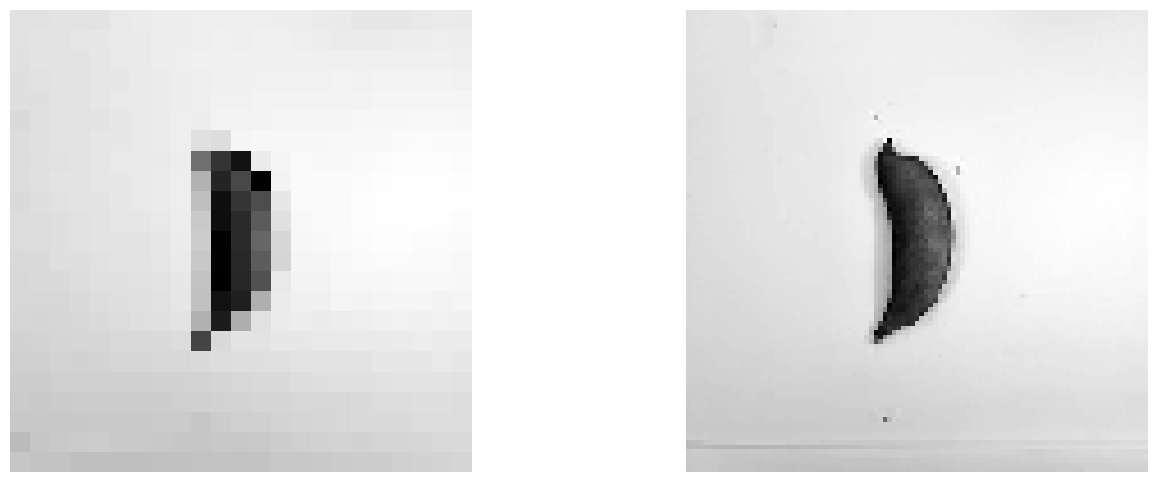

In [10]:
fig , ax = plt.subplots(1 , 2, figsize=(16 , 6))
ax[0].imshow(train_data_23['sequence'].iloc[0] , cmap='gray')
ax[0].axis('off')
ax[1].imshow(train_data_101['sequence'].iloc[0] , cmap='gray')
ax[1].axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_imap.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>


looks like a very nice bean

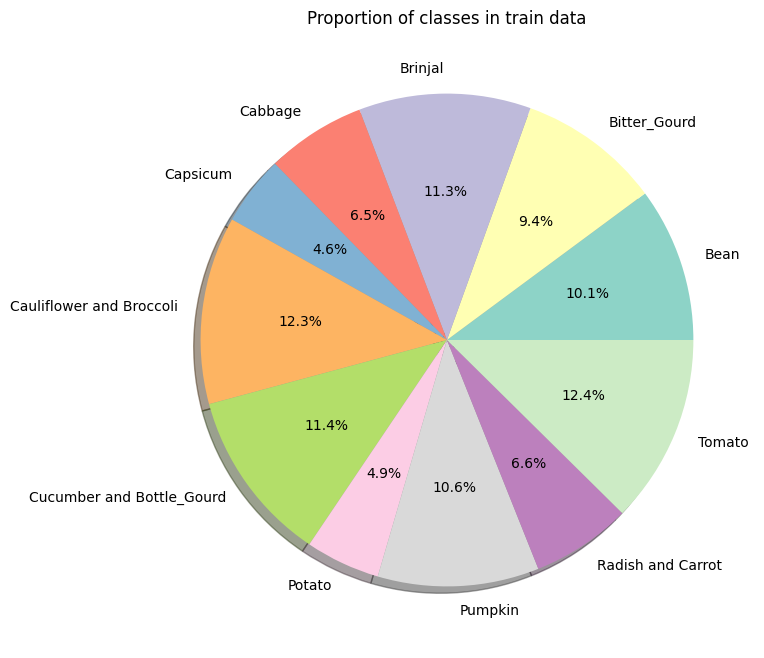

In [11]:
# Comparing classes
# Both classes are the same for 23 and 101 datasets

counts = []
for col in train_data_23.columns[1:]:
  amount_of_class = train_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=train_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in train data')
plt.show()

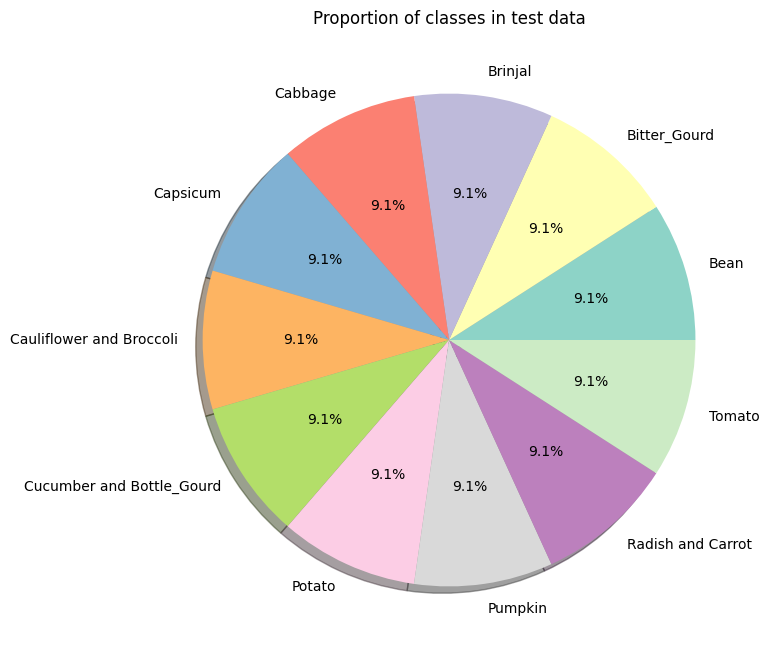

In [12]:
counts = []
for col in test_data_23.columns[1:]:
  amount_of_class = test_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=test_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in test data')
plt.show()

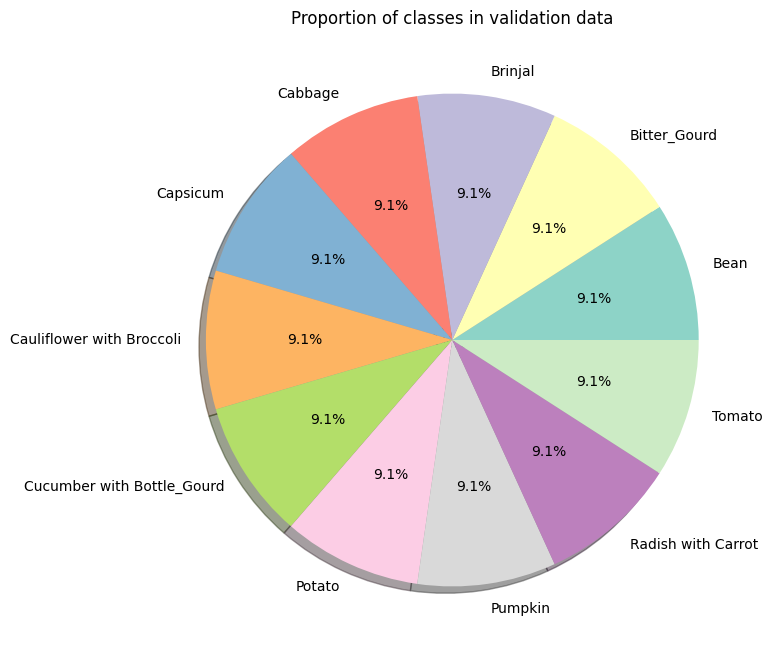

In [13]:
counts = []
for col in validation_data_23.columns[1:]:
  amount_of_class = validation_data_23[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=validation_data_23.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in validation data')
plt.show()

This shows that the train data has **unbalanced features** while the test and validation is **perfectly balanced**


This suggests that i should use metrics like recall when training

I can also attempt to use class weights when training to balance out the imbalanced data

##### Metrics

Due to the class imbalances, it is still a good idea to use a different metric from accuracy. 

**Why?**

Even with the class weights, the model might still learn to **prioritize the smaller classes** to minimize loss. 


I will create a custom callback for me to monitor the **f1-score**

This will be the main area of focus for my cnn

In [25]:
# 23
X_train_23 = np.asarray(np.stack(train_data_23['sequence']) , dtype=np.float32)
y_train_23 = np.asarray(train_data_23.drop(columns=['sequence']).values.astype(float), dtype=np.float32)

X_test_23 = np.stack(test_data_23['sequence'])
y_test_23 = test_data_23.drop(columns=['sequence']).values

X_validation_23 = np.asarray(np.stack(validation_data_23['sequence']), dtype=np.float32)
y_validation_23 = np.asarray(validation_data_23.drop(columns=['sequence']).values.astype(float) , dtype = np.float32)


# 101
X_train_101 = np.asarray(np.stack(train_data_101['sequence']) , dtype=np.float32)
y_train_101 = np.asarray(train_data_101.drop(columns=['sequence']).values.astype(float), dtype=np.float32)

X_test_101 = np.stack(test_data_101['sequence'])
y_test_101 = test_data_101.drop(columns=['sequence']).values

X_validation_101 = np.asarray(np.stack(validation_data_101['sequence']), dtype=np.float32)
y_validation_101 = np.asarray(validation_data_101.drop(columns=['sequence']).values.astype(float) , dtype = np.float32)

In [15]:
## Generating class weights
## These labels can be used for both sizes
# used only before data aug

y_train_labels = np.argmax(y_train_23, axis=1)
class_labels = np.unique(y_train_labels)
class_weights = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels,
  y=y_train_labels 
)

class_weights_dict = dict(enumerate(class_weights))

##### Is my data enough? 

One easy way to check if to create a very simple and generic model. We can also use this as our **baseline model**

We can train the data on the baseline model and **compare the val and train f1 scores**

**Ideally** we should see both the train and the val flatline


##### What will i do? 

I will slowly increase the amount of data inside of my train.

For each set of increase, i will plot the graph again to check if my data has flat-lined (plateaud)

In [23]:
# Creating metric for f1 score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        precision = logs['precision']
        recall = logs['recall']
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        logs['f1_score'] = f1_score

        precision = logs['val_precision']
        recall = logs['val_recall']
        f1_score = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
        logs['val_f1_score'] = f1_score

In [7]:
def create_baseline_model():
  baseline_model = Sequential([
    Conv2D(32, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),
    
    Conv2D(64, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),
    
    Conv2D(128, kernel_size=(5 , 5), padding='same'),
    BatchNormalization(),
    ReLU(), 
    MaxPooling2D((3 , 3), padding='same'),

    Dropout(0.7),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(11 , activation='softmax')
  ])

  baseline_model.compile(loss='categorical_crossentropy' , optimizer=Adam(learning_rate=1e-4) , metrics=[
    Precision(name='precision'), Recall(name='recall'), 'accuracy'
  ])
  return baseline_model

In [29]:
def evaluate_data_size(X_train , y_train , X_val,y_val, class_weights):
  # Training on splits in order to see if the f1 score plateaus 
  splits = [0.25, 0.5 , 0.75 , 1] 


  random.seed(42)
  last_4_val_f1 = []
  last_4_f1 = []
  for split in splits:
    print(f'Training on {split} of data size')

    # data handling
    if split != 1:
      X_train_split , _ ,y_train_split , _ = train_test_split(X_train, y_train, random_state=42 , train_size=split , stratify=y_train)
      X_train_split = np.asarray(X_train_split, dtype=np.float32)
      y_train_split = np.asarray(y_train_split, dtype=np.float32)
    else:
      X_train_split = np.asarray(X_train, dtype=np.float32)
      y_train_split = np.asarray(y_train, dtype=np.float32)

    X_validation = np.asarray(X_val, dtype=np.float32)
    y_validation = np.asarray(y_val, dtype=np.float32)

    early_stop = EarlyStopping(patience=10 , monitor='val_f1_score' ,restore_best_weights=True , mode='max') 
    baseline_model = create_baseline_model()
    base_model_fit_results = baseline_model.fit(X_train_split, y_train_split,
                       epochs=200,
                       batch_size=32 ,
                       validation_data=(X_validation , y_validation),
                       verbose=0,
                       class_weight=class_weights,
                       callbacks=[F1ScoreCallback() , early_stop]
    )

    last_4_val_f1.append(np.max(base_model_fit_results.history['val_f1_score']))
    last_4_f1.append(np.max(base_model_fit_results.history['f1_score']))

  # Plotting
  plt.plot(splits , last_4_val_f1, label='validation')
  plt.plot(splits , last_4_f1 , label='training')
  plt.title(f'Validation f1 against data splits')
  plt.xlabel('splits')
  plt.ylabel('val f1')
  plt.legend()
  plt.xticks(splits)
      
  plt.show()

Training on 0.25 of data size
Training on 0.5 of data size
Training on 0.75 of data size
Training on 1 of data size


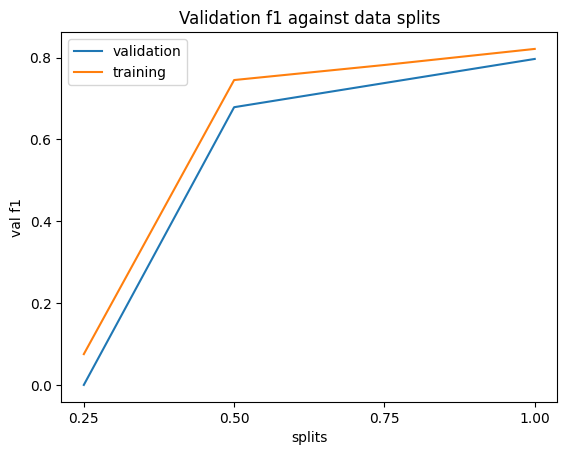

Increasing data
Training on 0.25 of data size
Training on 0.5 of data size
Training on 0.75 of data size
Training on 1 of data size


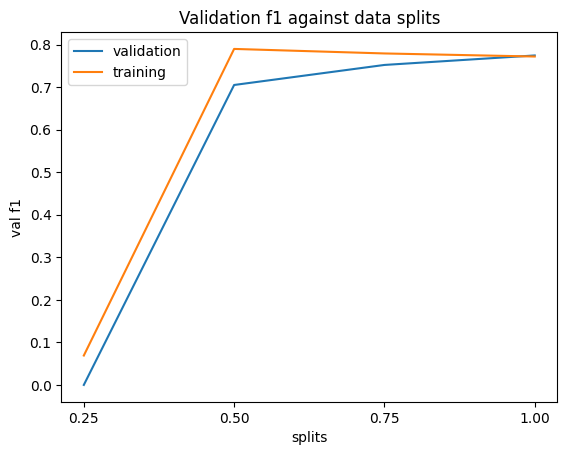

In [30]:
# evaluating data size for 
# Increase amount is going to be 20%

random.seed(44)

# dynamic increment of data based on visual inspect
evaluate_data_size(X_train_23, y_train_23 , X_validation_23, y_validation_23, class_weights_dict)
add_data = input('add more data? (y/n): ').lower()
while add_data == 'y':
  print('Increasing data')
  datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.8 , 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
  )
  
  X_train_23_augmented = np.stack(train_data_23['sequence'].values)
  y_train_23_augmented = np.stack(train_data_23.drop(columns=['sequence']).values)

  increase_amount = int(0.2 * len(X_train_23_augmented))

  # Convert one-hot vectors to class indices
  y_labels = np.argmax(y_train_23_augmented, axis=1)
  class_counts = pd.Series(y_labels).value_counts().sort_values()  # sort from smallest class

  X_new = []
  y_new = []

  total_new = 0

  for class_id in class_counts.index:
      if total_new >= increase_amount:
          break

      # get indices of this class
      class_indices = np.where(y_labels == class_id)[0]
      
      augment_count = min(50, increase_amount - total_new)
      selected_indices = np.random.choice(class_indices, augment_count, replace=True)
      
      for idx in selected_indices:
          sequence = X_train_23_augmented[idx].reshape((1,) + X_train_23_augmented[idx].shape)  
          label = y_train_23_augmented[idx]
          
          aug_img = next(datagen.flow(sequence, batch_size=1))[0]
          X_new.append(aug_img)
          y_new.append(label)
          total_new += 1

  # Final augmented data
  X_train_23_augmented = np.concatenate([X_train_23_augmented, np.array(X_new)], axis=0)
  y_train_23_augmented = np.concatenate([y_train_23_augmented, np.array(y_new)], axis=0)
    
  
  # create class weights on the new augmented data
  y_train_labels = np.argmax(y_train_23_augmented, axis=1)
  class_labels = np.unique(y_train_labels)
  class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels,
    y=y_train_labels 
  )

  class_weights_dict_23 = dict(enumerate(class_weights))
  # evaluate with the new augmented data
  evaluate_data_size(X_train_23_augmented , y_train_23_augmented, X_validation_23 , y_validation_23, class_weights_dict_23)
  add_data = input('add more data? (y/n): ').lower()
                     

THe initial raw data shows that it **hasn't plateaud**, Thus i added more points of data.

As i add more data, we see that the **training and validation have rougly flatlined**. The validation still slightly increasing while the training still slightly decreasing.

This can suggest that the model is generalizing quite well at this amount of data.

##### Why not add more data?

The increase in validation seems to have slowed down, suggesting that we have hit the **point of diminishing returns**. Adding more data is bound to improve it, but at **the cost of overfitting chances and more training time**

Training on 0.25 of data size


Training on 0.5 of data size
Training on 0.75 of data size
Training on 1 of data size


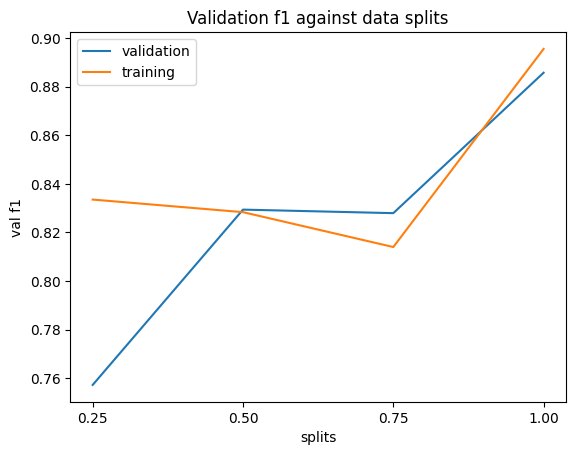

Increasing data
Training on 0.25 of data size
Training on 0.5 of data size
Training on 0.75 of data size
Training on 1 of data size


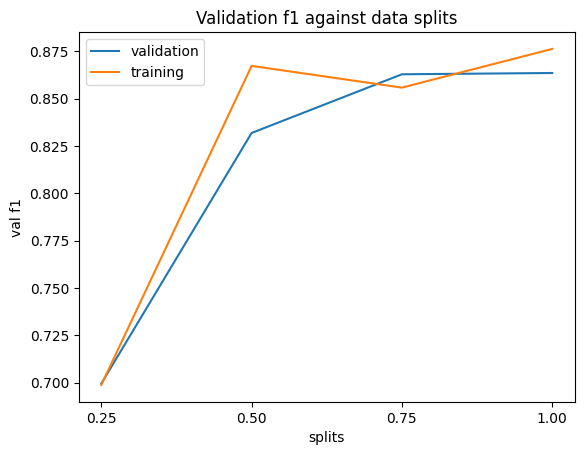

In [34]:
# same thing for 101
# evaluating data size for 
# Increase amount is going to be 20%

random.seed(44)

# dynamic increment of data based on visual inspect
evaluate_data_size(X_train_101, y_train_101 , X_validation_101, y_validation_101, class_weights_dict)
add_data = input('add more data? (y/n): ').lower()
while add_data == 'y':
  print('Increasing data')
  datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.8 , 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
  )
  
  X_train_101_augmented = np.stack(train_data_101['sequence'].values)
  y_train_101_augmented = np.stack(train_data_101.drop(columns=['sequence']).values)

  increase_amount = int(0.2 * len(X_train_101_augmented))

  # Convert one-hot vectors to class indices
  y_labels = np.argmax(y_train_101_augmented, axis=1)
  class_counts = pd.Series(y_labels).value_counts().sort_values()  # sort from smallest class

  X_new = []
  y_new = []

  total_new = 0

  for class_id in class_counts.index:
      if total_new >= increase_amount:
          break

      # get indices of this class
      class_indices = np.where(y_labels == class_id)[0]
      
      augment_count = min(50, increase_amount - total_new)
      selected_indices = np.random.choice(class_indices, augment_count, replace=True)
      
      for idx in selected_indices:
          sequence = X_train_101_augmented[idx].reshape((1,) + X_train_101_augmented[idx].shape)  
          label = y_train_101_augmented[idx]
          
          aug_img = next(datagen.flow(sequence, batch_size=1))[0]
          X_new.append(aug_img)
          y_new.append(label)
          total_new += 1

  # Final augmented data
  X_train_101_augmented = np.concatenate([X_train_101_augmented, np.array(X_new)], axis=0)
  y_train_101_augmented = np.concatenate([y_train_101_augmented, np.array(y_new)], axis=0)
    
  
  # create class weights on the new augmented data
  y_train_labels = np.argmax(y_train_101_augmented, axis=1)
  class_labels = np.unique(y_train_labels)
  class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=class_labels,
    y=y_train_labels 
  )

  class_weights_dict_101 = dict(enumerate(class_weights))
  # evaluate with the new augmented data
  gc.collect()
  evaluate_data_size(X_train_101_augmented , y_train_101_augmented, X_validation_101 , y_validation_101, class_weights_dict_101)
  add_data = input('add more data? (y/n): ').lower()

my 101 at the start clearly shows that validation and training data **is still increasing and have not plateaued**

After increasing the data, the validation has **flat-lined** suggesting that it has already **plateaued**


In [35]:
## Export this augmented data
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'X_train_101_cleaned') , X_train_101_augmented)
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'y_train_101_cleaned') , y_train_101_augmented)

np.save(os.path.join(STORED_DATA , 'cleaned_data', 'X_train_23_cleaned') , X_train_23_augmented)
np.save(os.path.join(STORED_DATA , 'cleaned_data', 'y_train_23_cleaned') , y_train_23_augmented)

In [10]:
# Then load the data
X_train_101_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'X_train_101_cleaned.npy'))
y_train_101_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'y_train_101_cleaned.npy'))

X_train_23_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'X_train_23_cleaned.npy'))
y_train_23_augmented = np.load(os.path.join(STORED_DATA, 'cleaned_data', 'y_train_23_cleaned.npy'))

Create new y classes for the new datasets (random sampled data aug)

In [11]:
y_train_labels_23 = np.argmax(y_train_23_augmented, axis=1)
class_labels_23 = np.unique(y_train_labels_23)
class_weights_23 = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels_23,
  y=y_train_labels_23
)

class_weights_dict_23 = dict(enumerate(class_weights_23))

In [12]:
y_train_labels_101 = np.argmax(y_train_101_augmented, axis=1)
class_labels_101 = np.unique(y_train_labels_101)
class_weights_101 = compute_class_weight(
  class_weight='balanced', 
  classes=class_labels_101,
  y=y_train_labels_101
)

class_weights_dict_101 = dict(enumerate(class_weights_101))

##### Predicting on Baseline Model

Epoch 1/100
258/258 [==============================] - 13s 9ms/step - loss: 3.3961 - precision: 0.1165 - recall: 0.0403 - accuracy: 0.1065 - val_loss: 2.5112 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0909 - f1_score: 0.0599 - val_f1_score: 0.0000e+00
Epoch 2/100
258/258 [==============================] - 2s 7ms/step - loss: 2.6646 - precision: 0.1675 - recall: 0.0199 - accuracy: 0.1337 - val_loss: 2.3303 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.1514 - f1_score: 0.0356 - val_f1_score: 0.0000e+00
Epoch 3/100
258/258 [==============================] - 2s 7ms/step - loss: 2.5120 - precision: 0.1985 - recall: 0.0129 - accuracy: 0.1434 - val_loss: 2.1947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.2895 - f1_score: 0.0242 - val_f1_score: 0.0000e+00
Epoch 4/100
258/258 [==============================] - 2s 7ms/step - loss: 2.3998 - precision: 0.2335 - recall: 0.0112 - accuracy: 0.1566 - val_loss: 2.1834 - val

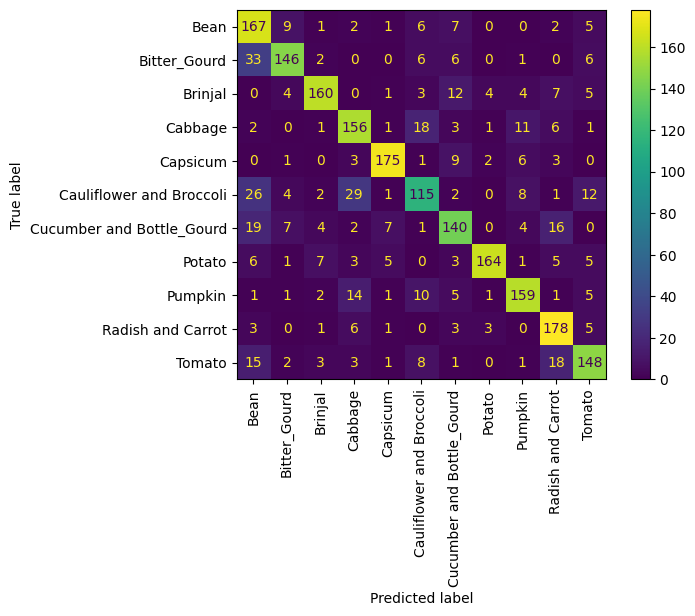

In [13]:
baseline_model_23 = create_baseline_model()
baseline_model_23.fit(
  X_train_23_augmented, y_train_23_augmented,
  epochs = 100,
  validation_data=(X_validation_23 , y_validation_23),
  verbose=1,
  batch_size=32,
  class_weight=class_weights_dict_23,
  callbacks=[F1ScoreCallback() ,EarlyStopping(patience=8, monitor='val_f1_score' , restore_best_weights=True , mode='max')]
)

y_pred = baseline_model_23.predict(X_test_23)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_23, axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

Epoch 1/100
255/255 [==============================] - 9s 28ms/step - loss: 2.1932 - precision: 0.4164 - recall: 0.0443 - accuracy: 0.2474 - val_loss: 3.3000 - val_precision: 0.0850 - val_recall: 0.0648 - val_accuracy: 0.0805 - f1_score: 0.0800 - val_f1_score: 0.0735
Epoch 2/100
255/255 [==============================] - 7s 26ms/step - loss: 1.8055 - precision: 0.6424 - recall: 0.1112 - accuracy: 0.3746 - val_loss: 3.0009 - val_precision: 0.5176 - val_recall: 0.0611 - val_accuracy: 0.1383 - f1_score: 0.1896 - val_f1_score: 0.1092
Epoch 3/100
255/255 [==============================] - 6s 22ms/step - loss: 1.6371 - precision: 0.6940 - recall: 0.1744 - accuracy: 0.4386 - val_loss: 1.4917 - val_precision: 0.8264 - val_recall: 0.1850 - val_accuracy: 0.5097 - f1_score: 0.2787 - val_f1_score: 0.3023
Epoch 4/100
255/255 [==============================] - 6s 22ms/step - loss: 1.5148 - precision: 0.7103 - recall: 0.2228 - accuracy: 0.4785 - val_loss: 1.3004 - val_precision: 0.8453 - val_recall: 

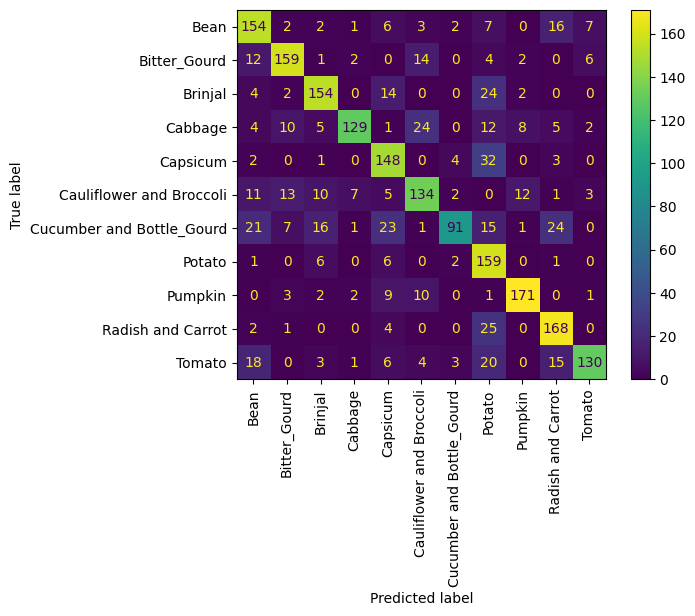

In [14]:

baseline_model_101 = create_baseline_model()
baseline_model_101.fit(
  X_train_101_augmented, y_train_101_augmented,
  epochs = 100,
  validation_data = (X_validation_101 , y_validation_101),
  verbose=1,
  batch_size=32,
  class_weight=class_weights_dict_101,
  callbacks=[F1ScoreCallback() ,EarlyStopping(patience=5, monitor='val_f1_score' , restore_best_weights=True, mode='max')]
)

y_pred = baseline_model_101.predict(X_test_101)
y_pred = np.argmax(y_pred , axis=1)
y_test = np.argmax(y_test_101, axis=1)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

##### Creating Model

The Idea behind my model is going to be as follows:

1. Input Layer
2. Conv2d * **n** amounts
3. BatchNormalize
4. Activation Relu
5. Maxpooling/bottleneck layer
6. Flatten
7. Dense - softmax (we are doing multiclass-classification)

where layers 2-5 can be repeated **m** times.

For the Search, since i already have dedicated validation data, i will not be using kfold-cv.

##### Why normalization before Activation?

This is the **ResNet50 Architecture**

In [21]:
def create_model(n , m, 
            dropout, kernel_size, strides, padding, activation,
            kernel_regularization, activity_regularization,
            pooling_size,
            lr
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(neurons_arr[-1] *2)
  
  for i in range(m):
    # Adding n number of conv2d
    for _ in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding, kernel_regularizer=l2(kernel_regularization), activity_regularizer=l1(activity_regularization)))

    # Batch Norm before Activatoin follows the resnet50 architecture
    model.add(BatchNormalization())
    model.add(eval(f'{activation}()'))
    model.add(MaxPooling2D((pooling_size) , padding='same'))

  
  model.add(Dropout(dropout))
  model.add(GlobalAveragePooling2D())
  model.add(Dense(128 , activation='relu'))
  model.add(Dropout(0.3)) # prevents overfitting from the previous dense layer
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer=Adam(learning_rate=lr), metrics=[
    Precision(name='precision') , Recall(name='recall'), 'accuracy'
  ])
  return model
 
  


Note that tensor objects are **not used** in this param grid to ensure that it can be serialized and stored (using pickle) 

errors will occur if i try to use ReLu() tensorflow object


In [ ]:
hyper_params = { 
  'n': np.arange(1 , 5),
  'm': np.arange(2 , 5),
  'dropout': np.arange(0.3 , 0.8 , 0.1),# 5
  'strides': [(1 , 1)],
  'padding': ['same'],
  'activation': ['ReLU' , 'LeakyReLU'],
  'kernel_size': [(3 , 3), (5 , 5)],
  'kernel_regularization': [0 , 1e-5 , 1e-6],
  'activity_regularization': [0 , 1e-6 , 1e-7],
  'pooling_size': [(2 ,2 ) , (3 ,3)],
  'lr': [1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3]
}
batch_sizes = [32 ,48 ,64] 
val_losses = []
val_accuracies = []
val_recalls = []
fit_results = []
successful_params = []


##### Hyper parameter Tuning

In [ ]:
random.seed(42)
random_samples = random.sample(list(ParameterGrid(hyper_params)), 10)
# Random Search
for params in random_samples:
  for batch_size in batch_sizes:
    try:
      K.clear_session() # save gpu memory
      print(f'Tuning for {params}... \nbatch size {batch_size}')

      # Create and fit
      model = create_model(**params)
      early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
      fit_result = model.fit(
                X_train_23_augmented, y_train_23_augmented, epochs=100 , 
                batch_size=batch_size, 
                validation_data=(X_validation_23, y_validation_23) ,
                class_weight=class_weights_dict_23
                , callbacks=[F1ScoreCallback() , early_stop]
                ,verbose = 0
                )

      # Eval and store 
      # will not be using cross val score since we have dedicated vaildation data.
      val_loss , val_precision ,val_recall, val_accuracy= model.evaluate(X_validation_23 , y_validation_23)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_recalls.append(val_recall)
      fit_results.append(fit_result.history)
      successful_params.append(dict(params , **{'batch_size': batch_size})) # this is required since im skipping bad params

      print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}, val recall: {val_recall}')
      print(f'Val precision: {val_precision} , val f1: {2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))}')

      # predict + cm
      y_pred = np.argmax(model.predict(X_validation_23) , axis = 1)
      y_test = np.argmax(y_test_23, axis=1)
      print(classification_report(y_test, y_pred))

      cm = confusion_matrix(y_test, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
      disp.plot()
      plt.xticks(rotation=90)
      plt.show()

    except Exception as error:
      # handles any bad params configurations
      print('Error occured with this param configuration')
      print(error)
      continue
K.clear_session()

Tuning for {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.7000000000000002, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 4, 'n': 1, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1)}... 
batch size 32
69/69 [==============================] - 0s 5ms/step - loss: 0.9646 - precision: 0.7881 - recall: 0.6932 - accuracy: 0.7314
Val loss: 0.9645611047744751 , val_accuracy: 0.7313636541366577, val recall: 0.6931818127632141
Val precision: 0.7881137132644653 , val f1: 0.7376057592085292
Tuning for {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.7000000000000002, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 4, 'n': 1, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1)}... 
batch size 64
69/69 [==============================] - 0s 5ms/step - loss: 1.2120 - precision: 0.7567 - recall: 0.7155 - accuracy: 0.7282
Val loss: 1.2120428085327148 , val_accuracy: 0.7281818389892578, val recall: 0.7154545187950134
Val precision

In [ ]:
validation_f1 = [np.max(res['val_f1_score']) for res in fit_results]

In [ ]:
# Exporting 
results = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'validation_f1': validation_f1,
  'fit_results': fit_results
})

In [ ]:
# attempt to pickle, if error just use .json format
with open(os.path.join('tuning_results' , '23_tuning_results_v4.pkl') , 'wb') as f:
  pickle.dump(results, f)

In [13]:
# Importing the results
results_23 = None

with open(os.path.join('tuning_results' , '23_tuning_results_v4.pkl') , 'rb') as f:
  results_23 = pickle.load(f)


##### Tuning for 101

In [ ]:
# redefined
val_losses = []
val_accuracies = []
val_recalls = []
fit_results = []
successful_params = []

In [ ]:
gc.collect()

35507

In [ ]:
random_samples = random.sample(list(ParameterGrid(hyper_params)),10)
# Random Search
for params in random_samples:
  for batch_size in [32 , 64]:
    try:
      K.clear_session() # save gpu memory
      print(f'Tuning for {params}... \nbatch size {batch_size}')

      # Create and fit
      model = create_model(**params)
      early_stop = EarlyStopping(monitor='val_f1_score' , patience=10 , restore_best_weights=True, mode='max')
      fit_result = model.fit(
                X_train_101_augmented, y_train_101_augmented, epochs=100 , 
                batch_size=batch_size, 
                validation_data=(X_validation_101, y_validation_101) ,
                class_weight=class_weights_dict_101
                , callbacks=[F1ScoreCallback() , early_stop]
                ,verbose = 0
                )

      # Eval and store 
      # will not be using cross val score since we have dedicated vaildation data.
      val_loss , val_precision ,val_recall, val_accuracy= model.evaluate(X_validation_101 , y_validation_101)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_recalls.append(val_recall)
      fit_results.append(fit_result.history)
      successful_params.append(dict(params , **{'batch_size': batch_size})) # this is required since im skipping bad params

      print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}, val recall: {val_recall}')
      print(f'Val precision: {val_precision} , val f1: {2 * ((val_precision * val_recall) / (val_precision + val_recall + K.epsilon()))}')

      # predict + cm
      y_pred = np.argmax(model.predict(X_validation_101) , axis = 1)
      y_test = np.argmax(y_test_101, axis=1)
      print(classification_report(y_test, y_pred))

      cm = confusion_matrix(y_test, y_pred)
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
      disp.plot()
      plt.xticks(rotation=90)
      plt.show()

      # 101 takes alot of space so i need to clear up my vram
      del model
    except Exception as error:
      # handles any bad params configurations
      print('Error occured with this param configuration')
      print(error)
      # we assume that the error is from overloaded memory
      gc.collect()
      break
K.clear_session()

Tuning for {'activation': 'LeakyReLU', 'activity_regularization': 0, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 32
68/68 [==============================] - 2s 33ms/step - loss: 1.7228 - precision: 0.5793 - recall: 0.4510 - accuracy: 0.5037
Val loss: 1.7227962017059326 , val_accuracy: 0.5037002563476562, val recall: 0.4509713351726532
Val precision: 0.5793226361274719 , val f1: 0.5071521034387134
Tuning for {'activation': 'LeakyReLU', 'activity_regularization': 0, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 64
68/68 [==============================] - 2s 32ms/step - loss: 1.2839 - precision: 0.6582 - recall: 0.5888 - accuracy: 0.6253
Val loss: 1.2838726043701172 , val_accuracy: 0.6253468990325928, val recall: 0.588806688785553
Val precision: 0.6582213

In [ ]:
validation_f1 = [np.max(res['val_f1_score']) for res in fit_results]

In [ ]:
# Exporting 
results_101 = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'validation_f1': validation_f1,
  'fit_results': fit_results
})

In [ ]:
# attempt to pickle, if error just use .json format
with open(os.path.join('tuning_results' , '101_tuning_results_v4.pkl') , 'wb') as f:
  pickle.dump(results_101, f)

In [14]:
# Importing the results
results_101 = None

with open(os.path.join('tuning_results' , '101_tuning_results_v4.pkl') , 'rb') as f:
  results_101 = pickle.load(f)

##### Evaluating and choosing params

In [15]:
# Deconstructing Results

val_accuracies_23 = results_23['validation_accuracies']
val_losses_23 = results_23['validation_losses']
val_f1_23 = results_23['validation_f1']
successful_params_23 = results_23['params']
fit_results_23 = results_23['fit_results']
                   
val_accuracies_101 = results_101['validation_accuracies']
val_losses_101 = results_101['validation_losses']
val_f1_101 = results_101['validation_f1']
successful_params_101 = results_101['params']
fit_results_101 = results_101['fit_results']

##### Best Model Analysis

In [16]:
best_index_23 = np.argmax(val_f1_23)
best_index_101 = np.argmax(val_f1_101)

In [17]:
print(f'Best_params 23: {successful_params_23[best_index_23]}')
print(f'Best_f1 23: {val_f1_23[best_index_23]}')
print(f'Best_params 101: {successful_params_101[best_index_101]}')
print(f'Best_f1 101: {val_f1_101[best_index_101]}')

Best_params 23: {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-05, 'kernel_size': (5, 5), 'm': 3, 'n': 2, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 32}
Best_f1 23: 0.8850205628651956
Best_params 101: {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
Best_f1 101: 0.9517819271713465


<style>
  /*responsive*/
  img {
    width: 100%;
    height: auto
  }
  </style>
##### Where is the learning rate?

The learning rate isn't stored in this set of tuning result

This set of tuning results is from a previous iteration whichh can be found at  `./previous_iterations/CNN_v4_part1.ipynb`


The best learning rates from that file are:

| Size | LR     |
|------|--------|
| 23   | 0.003  |
| 101  | 3e-5   |


### Results from CNN V4 Part 1

##### 23x23

```txt
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       200
           1       0.90      0.94      0.92       200
           2       0.89      0.96      0.92       200
           3       0.82      0.78      0.80       200
           4       0.95      0.91      0.93       200
           5       0.79      0.78      0.78       200
           6       0.84      0.92      0.88       200
           7       0.87      0.91      0.89       200
           8       0.89      0.73      0.81       200
           9       0.93      0.87      0.90       200
          10       0.82      0.92      0.86       200

    accuracy                           0.87      2200
   macro avg       0.87      0.87      0.87      2200
weighted avg       0.87      0.87      0.87      2200
```
<img src='./markdown/learning_rate_tuning_results_23.png'>

This had the highest f1-score among all other lrs

---

##### 101x101

For 101 there were 2 learning rates with similar scores

1. 3e-5

```txt

              precision    recall  f1-score   support

           0       0.96      0.90      0.93       200
           1       0.97      0.92      0.94       200
           2       0.99      0.87      0.93       200
           3       0.91      0.90      0.91       200
           4       0.93      0.94      0.93       190
           5       0.93      0.83      0.88       198
           6       0.82      0.97      0.89       200
           7       0.86      0.95      0.90       175
           8       0.92      0.93      0.92       199
           9       0.92      0.96      0.94       200
          10       0.90      0.90      0.90       200

    accuracy                           0.92      2162
   macro avg       0.92      0.92      0.92      2162
weighted avg       0.92      0.92      0.92      2162
```

<img src='./markdown/learning_rate_tuning_results_101_3e-5.png'>

2. 1e-5

```txt

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       200
           1       0.97      0.94      0.95       200
           2       0.91      0.90      0.91       200
           3       0.94      0.85      0.90       200
           4       0.91      0.95      0.93       190
           5       0.82      0.92      0.87       198
           6       0.93      0.86      0.90       200
           7       0.94      0.91      0.92       175
           8       0.92      0.95      0.93       199
           9       0.99      0.88      0.93       200
          10       0.86      0.98      0.92       200

    accuracy                           0.92      2162
   macro avg       0.92      0.92      0.92      2162
weighted avg       0.92      0.92      0.92      2162
```

<img src='./markdown/learning_rate_tuning_results_101_1e-5.png'>


##### Why 3e-05 not 1e-05 for 101?

while they both have the same performance, i decided to decide by comparing the **std of f1 scores accross all classes**

3e-05 has 0.019708621262435 std while 1e-05 has 0.20489868490154 std

This suggests that lr of 3e-05 can **generalize across all classes better**

---

##### Making Predictions

I will use early stop with patience 10. 

With **restore_best_weights**, it should be able to capture the point **right before overfitting**

Though if i feel like it is unable to i will analyse the graph further and manually set the epoch

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-05, 'kernel_size': (5, 5), 'm': 3, 'n': 2, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 32}
Epoch 1/50
258/258 [==============================] - 6s 17ms/step - loss: 2.0277 - precision: 0.5530 - recall: 0.0708 - accuracy: 0.3103 - val_loss: 3.1047 - val_precision: 0.1549 - val_recall: 0.0750 - val_accuracy: 0.0973 - f1_score: 0.1256 - val_f1_score: 0.1011
Epoch 2/50
258/258 [==============================] - 3s 13ms/step - loss: 1.5656 - precision: 0.6734 - recall: 0.2662 - accuracy: 0.4918 - val_loss: 3.0400 - val_precision: 0.2988 - val_recall: 0.2100 - val_accuracy: 0.2545 - f1_score: 0.3815 - val_f1_score: 0.2467
Epoch 3/50
258/258 [==============================] - 4s 14ms/step - loss: 1.2950 - precision: 0.7380 - recall: 0.4211 - accuracy: 0.5872 - val_loss: 2.3088 - val_precision: 0.3748 - val_recall: 0.2618 - val_accuracy: 0.3227 - f1_scor

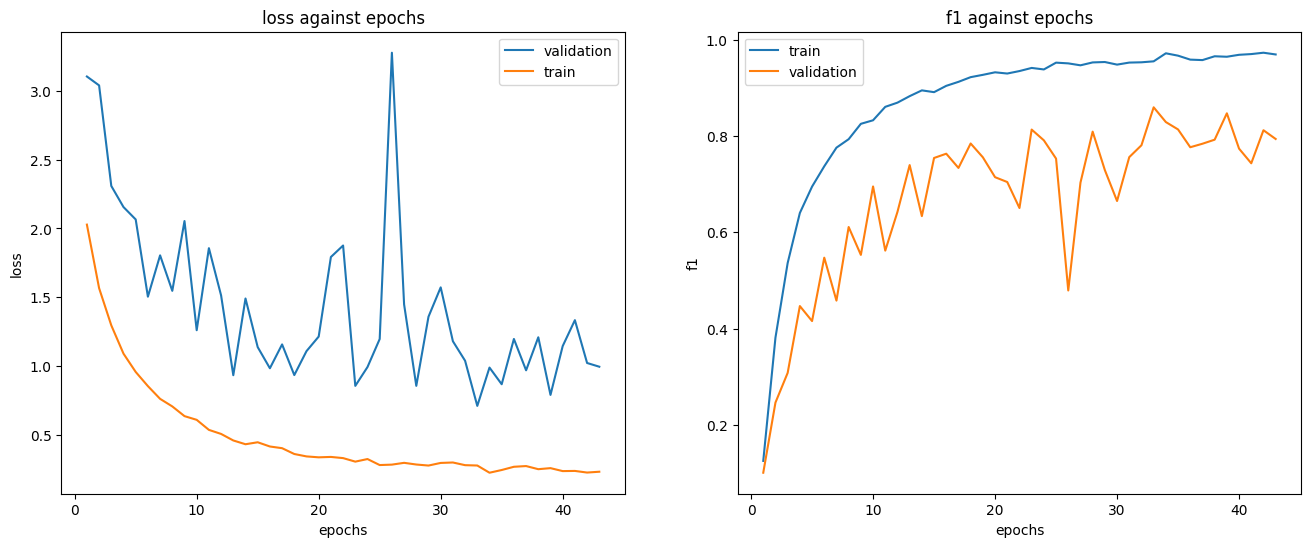

69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.73      0.91      0.81       200
           1       0.76      0.91      0.82       200
           2       0.91      0.79      0.85       200
           3       0.87      0.81      0.83       200
           4       0.83      0.98      0.90       200
           5       0.76      0.69      0.72       200
           6       0.93      0.85      0.89       200
           7       0.95      0.82      0.88       200
           8       0.88      0.88      0.88       200
           9       0.96      0.92      0.94       200
          10       0.87      0.82      0.84       200

    accuracy                           0.85      2200
   macro avg       0.86      0.85      0.85      2200
weighted avg       0.86      0.85      0.85      2200



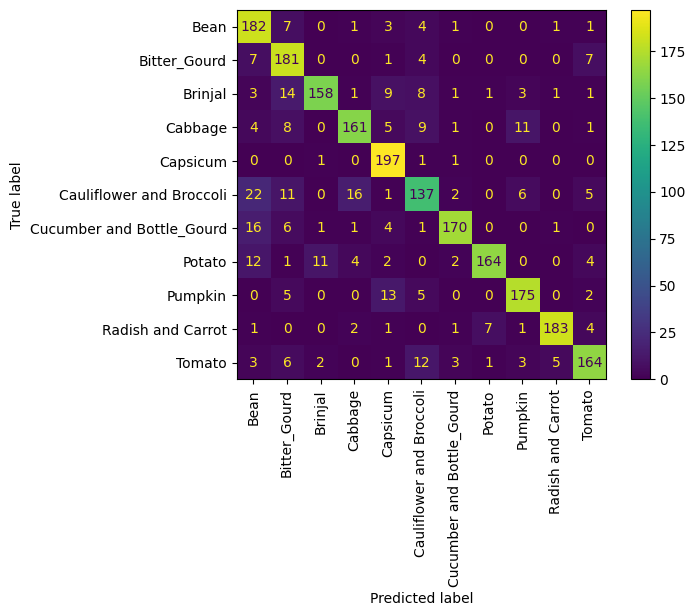

In [25]:
params = successful_params_23[best_index_23] 
print(f'Testing {successful_params_23[best_index_23]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_size_23_v4_v2.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params , lr=1e-3)
results = model.fit(X_train_23_augmented, y_train_23_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_23, y_validation_23),
                    class_weight=class_weights_dict_23,
                    verbose=1
                    )

# plotting
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(results.history['loss']) + 1)

# loss
ax[0].plot(epochs , results.history['val_loss'], label='validation')
ax[0].plot(epochs , results.history['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , results.history['f1_score'] , label='train')
ax[1].plot(epochs , results.history['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()


# predict
y_pred = model.predict(X_test_23)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_23, axis=1)
print(classification_report(y_test_labels , y_pred))

cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

### 101 x 101

Now i can do the exact same steps for 101x101 size

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
Epoch 1/50
128/128 [==============================] - 21s 144ms/step - loss: 2.3557 - precision: 0.5210 - recall: 0.0668 - accuracy: 0.2766 - val_loss: 2.6802 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.0805 - f1_score: 0.1185 - val_f1_score: 0.0000e+00
Epoch 2/50
128/128 [==============================] - 17s 136ms/step - loss: 1.7691 - precision: 0.7070 - recall: 0.2314 - accuracy: 0.4773 - val_loss: 3.0928 - val_precision: 0.0726 - val_recall: 0.0592 - val_accuracy: 0.0805 - f1_score: 0.3486 - val_f1_score: 0.0652
Epoch 3/50
128/128 [==============================] - 17s 135ms/step - loss: 1.4468 - precision: 0.7763 - recall: 0.3753 - accuracy: 0.5859 - val_loss: 3.3028 - val_precision: 0.1319 - val_recall: 0.0500 - val_accuracy

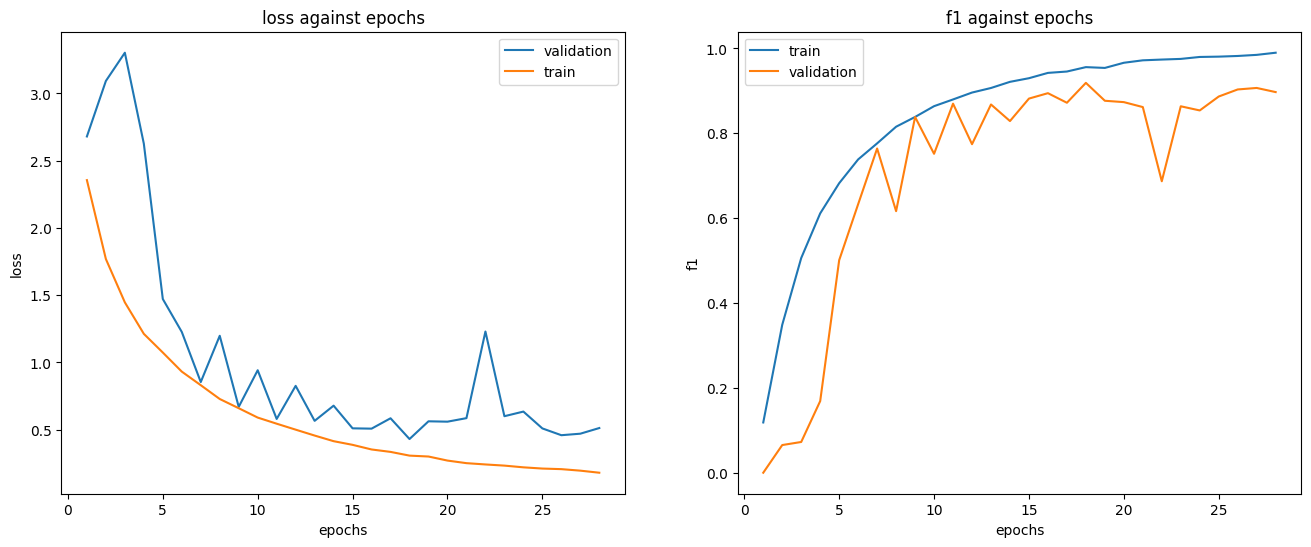

68/68 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.94      0.85      0.90       200
           1       0.96      0.93      0.94       200
           2       0.90      0.94      0.92       200
           3       0.87      0.87      0.87       200
           4       0.92      0.95      0.94       190
           5       0.90      0.79      0.84       198
           6       0.88      0.90      0.89       200
           7       0.86      0.97      0.91       175
           8       0.91      0.91      0.91       199
           9       0.87      0.96      0.91       200
          10       0.91      0.88      0.90       200

    accuracy                           0.90      2162
   macro avg       0.90      0.90      0.90      2162
weighted avg       0.90      0.90      0.90      2162



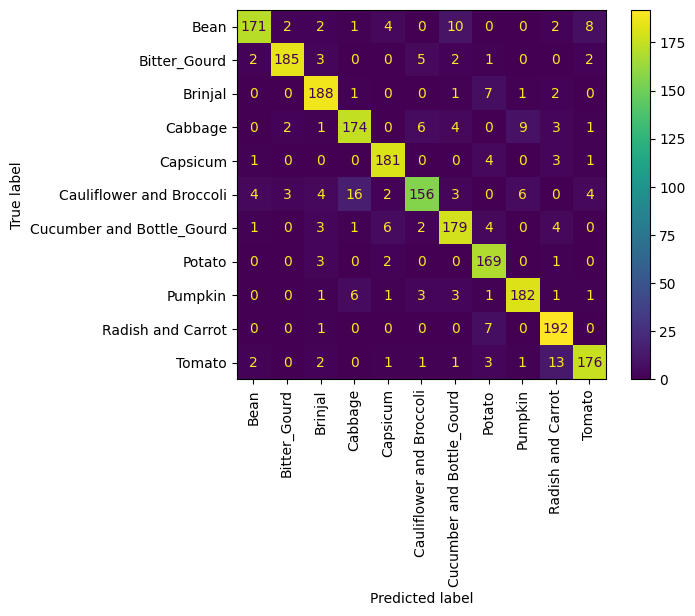

In [26]:
params = successful_params_101[best_index_101] 
print(f'Testing {successful_params_101[best_index_101]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_size_101_v4_v2.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params, lr=3e-05)
results = model.fit(X_train_101_augmented, y_train_101_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_101, y_validation_101),
                    class_weight=class_weights_dict_101,
                    verbose=1
                    )
# plotting
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(results.history['val_loss']) + 1)

# loss
ax[0].plot(epochs , results.history['val_loss'], label='validation')
ax[0].plot(epochs , results.history['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , results.history['f1_score'] , label='train')
ax[1].plot(epochs , results.history['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()

# predict
y_pred = model.predict(X_test_101)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_101, axis=1)
print(classification_report(y_test_labels , y_pred))
cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

##### Evaluating Results

Overall the 101x101 dataset seems to generalize quite well across all classes.

However, the 23x23 dataset has alot of difficulties with **Cauliflower and Brocolli** 

It also seems to predict alot more **Bean and Bitter_Gourd** across all classes

**Solution**

We can slowly play around with the **class weights for Cauliflower**, this will penalize Cauliflowers more, effectively tell the model to **'focus on Cauliflowers'**

Likewise we can slightly decrease the **Bean and Bitter_Gourd class weights**


In [18]:
class_weights_dict_23

{0: 0.9028477546549836,
 1: 0.9731995277449823,
 2: 0.8163002574767281,
 3: 1.3575428194993413,
 4: 1.868737247789617,
 5: 0.750865367097832,
 6: 0.8101228501228501,
 7: 1.7549499680647223,
 8: 0.8673190235690236,
 9: 1.3526419428946506,
 10: 0.7463781238681637}

Increasing class weights by 0.1
69/69 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       200
           1       0.94      0.80      0.86       200
           2       0.94      0.87      0.90       200
           3       0.81      0.80      0.81       200
           4       0.94      0.93      0.93       200
           5       0.75      0.80      0.77       200
           6       0.89      0.88      0.88       200
           7       0.76      0.95      0.85       200
           8       0.93      0.77      0.84       200
           9       0.82      0.92      0.87       200
          10       0.85      0.82      0.84       200

    accuracy                           0.86      2200
   macro avg       0.86      0.86      0.86      2200
weighted avg       0.86      0.86      0.86      2200



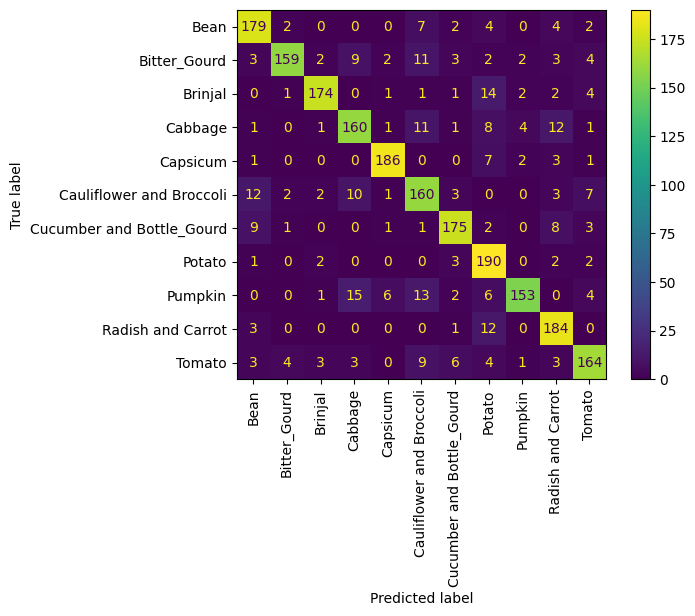

Increasing class weights by 0.2
69/69 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       200
           1       0.93      0.76      0.83       200
           2       0.79      0.77      0.78       200
           3       0.88      0.73      0.80       200
           4       0.97      0.84      0.90       200
           5       0.94      0.48      0.64       200
           6       0.71      0.89      0.79       200
           7       0.73      0.90      0.80       200
           8       0.88      0.88      0.88       200
           9       0.83      0.95      0.89       200
          10       0.73      0.85      0.79       200

    accuracy                           0.81      2200
   macro avg       0.83      0.81      0.80      2200
weighted avg       0.83      0.81      0.80      2200



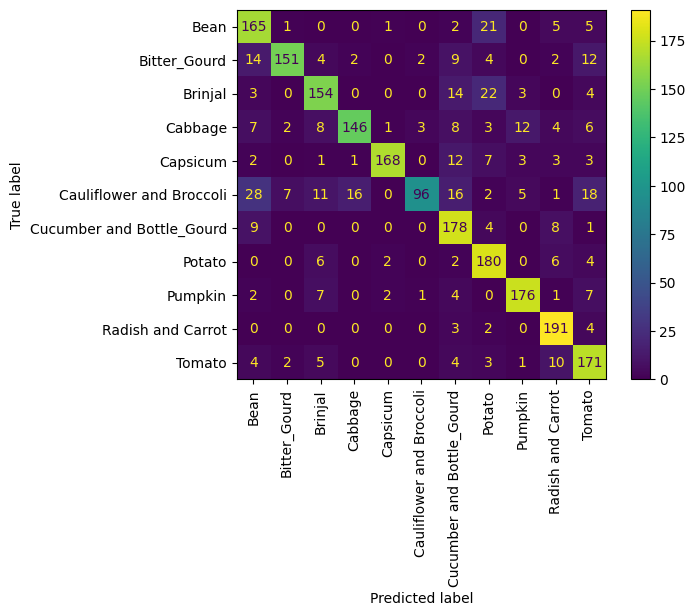

Increasing class weights by 0.30000000000000004
69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.71      0.80       200
           1       0.83      0.84      0.84       200
           2       0.72      0.90      0.80       200
           3       0.86      0.77      0.81       200
           4       0.97      0.86      0.91       200
           5       0.65      0.81      0.72       200
           6       0.90      0.88      0.89       200
           7       0.93      0.70      0.80       200
           8       0.81      0.92      0.86       200
           9       0.90      0.90      0.90       200
          10       0.79      0.84      0.81       200

    accuracy                           0.83      2200
   macro avg       0.84      0.83      0.83      2200
weighted avg       0.84      0.83      0.83      2200



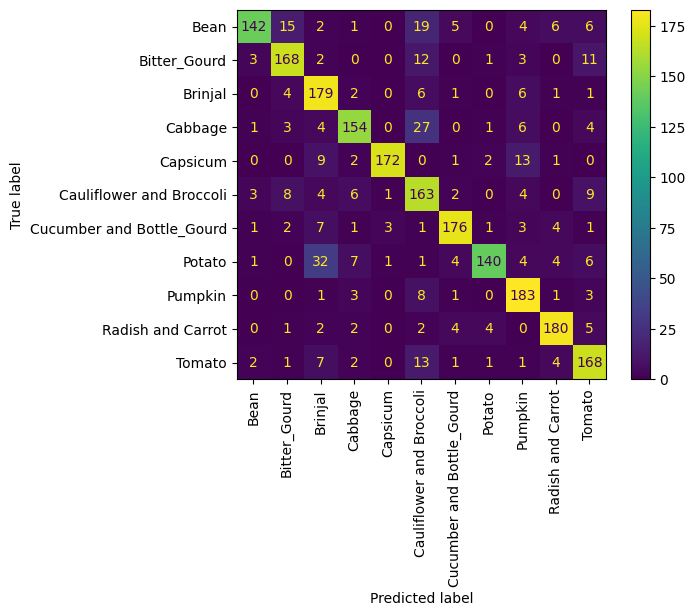

In [26]:
# slight increases by 0.1 3 times

for i in range(1 , 4):
  new_classweights_dict = class_weights_dict_23
  new_classweights_dict[5] += 0.1 * i
  new_classweights_dict[0] -= 0.05
  new_classweights_dict[1] -= 0.05

  print(f'Increasing class weights by {0.10 * i}')

  #############################################################
  # same code as above
  #############################################################
  params = successful_params_23[best_index_23] 
  model_params = {k:v for k , v in params.items() if k != 'batch_size'}
  # callbacks
  early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')

  # fitting
  model = create_model(**model_params , lr=1e-3)
  results = model.fit(X_train_23_augmented, y_train_23_augmented,
                      epochs=50,
                      batch_size=params['batch_size'],
                      callbacks=[F1ScoreCallback() , early_stopper],
                      validation_data = (X_validation_23, y_validation_23),
                      class_weight=new_classweights_dict,
                      verbose=0
                      )
  # predict
  y_pred = model.predict(X_test_23)
  y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

  ## results
  y_test_labels = np.argmax(y_test_23, axis=1)
  print(classification_report(y_test_labels , y_pred))

  cm = confusion_matrix(y_test_labels , y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
  disp.plot()
  plt.xticks(rotation=90)
  plt.show()

Our model is able to generalize quite well at 0.1 class weights increase

In [27]:
class_weights_dict_23[0] -= 0.05
class_weights_dict_23[1] -= 0.05
class_weights_dict_23[5] += 0.1

It seems that 101 is slightly underfitted on the cauliflower and broccoli as well. so we can try to play around with those weights slightly

Increasing class weights by 0.05
68/68 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       200
           1       0.92      0.83      0.87       200
           2       0.90      0.72      0.80       200
           3       0.61      0.94      0.74       200
           4       0.48      0.98      0.64       190
           5       0.91      0.58      0.71       198
           6       0.83      0.80      0.82       200
           7       0.93      0.23      0.37       175
           8       0.95      0.74      0.83       199
           9       0.86      0.78      0.81       200
          10       0.74      0.89      0.81       200

    accuracy                           0.76      2162
   macro avg       0.82      0.76      0.75      2162
weighted avg       0.82      0.76      0.76      2162



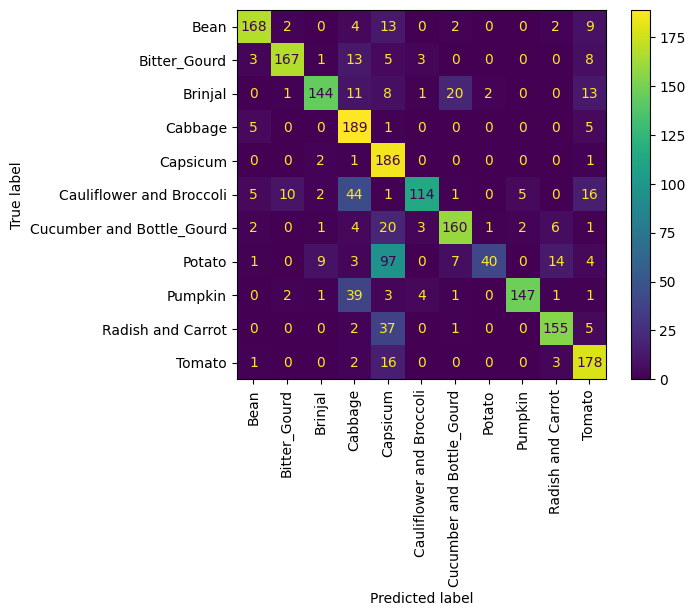

Increasing class weights by 0.1
68/68 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.77      0.99      0.86       200
           1       0.94      0.93      0.93       200
           2       0.98      0.81      0.88       200
           3       0.85      0.95      0.90       200
           4       0.96      0.97      0.97       190
           5       0.96      0.89      0.92       198
           6       0.85      0.88      0.86       200
           7       0.91      0.95      0.93       175
           8       0.97      0.86      0.91       199
           9       0.99      0.91      0.95       200
          10       0.98      0.94      0.96       200

    accuracy                           0.92      2162
   macro avg       0.92      0.92      0.92      2162
weighted avg       0.92      0.92      0.92      2162



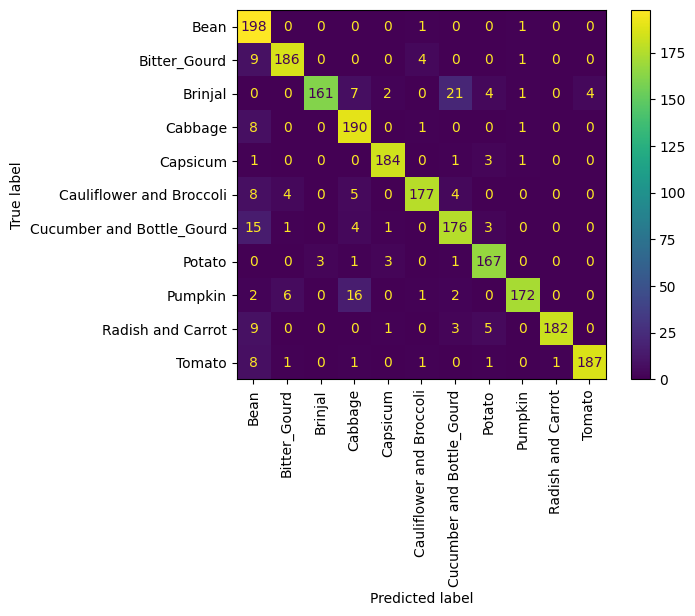

Increasing class weights by 0.15000000000000002
68/68 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       200
           1       0.92      0.99      0.95       200
           2       0.99      0.78      0.87       200
           3       0.97      0.82      0.89       200
           4       0.98      0.88      0.93       190
           5       0.90      0.95      0.93       198
           6       0.90      0.95      0.92       200
           7       0.67      1.00      0.80       175
           8       0.90      0.97      0.93       199
           9       0.85      0.84      0.85       200
          10       0.99      0.83      0.91       200

    accuracy                           0.90      2162
   macro avg       0.91      0.90      0.90      2162
weighted avg       0.92      0.90      0.90      2162



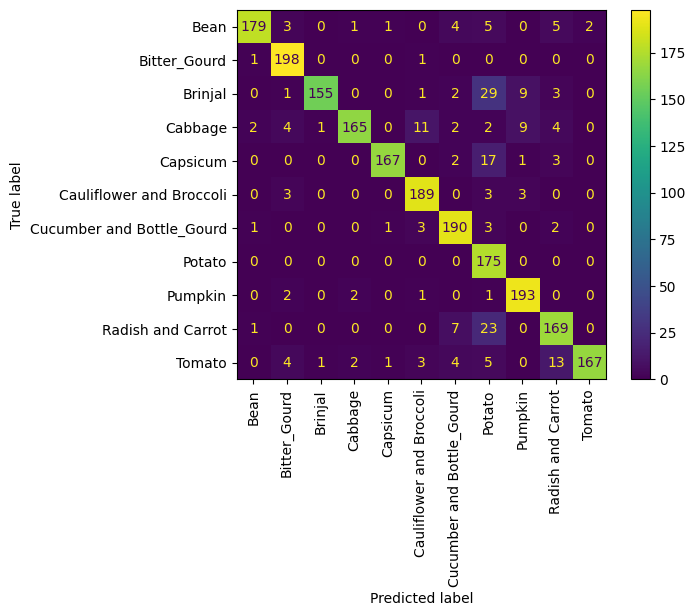

In [28]:
# slight increases by 0.05 3 times

for i in range(1 , 4):
  new_classweights_dict = class_weights_dict_101
  new_classweights_dict[5] += 0.05 * i

  print(f'Increasing class weights by {0.05 * i}')

  #############################################################
  # same code as above
  #############################################################
  params = successful_params_101[best_index_101] 
  model_params = {k:v for k , v in params.items() if k != 'batch_size'}
  # callbacks
  early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')

  # fitting
  model = create_model(**model_params , lr=1e-3)
  results = model.fit(X_train_101_augmented, y_train_101_augmented,
                      epochs=50,
                      batch_size=params['batch_size'],
                      callbacks=[F1ScoreCallback() , early_stopper],
                      validation_data = (X_validation_101, y_validation_101),
                      class_weight=new_classweights_dict,
                      verbose=0
                      )
  # predict
  y_pred = model.predict(X_test_101)
  y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

  ## results
  y_test_labels = np.argmax(y_test_101, axis=1)
  print(classification_report(y_test_labels , y_pred))

  cm = confusion_matrix(y_test_labels , y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
  disp.plot()
  plt.xticks(rotation=90)
  plt.show()

Increasing the weights by 0.1 seems to help improve it

In [31]:
class_weights_dict_101[5] += 0.1

##### Final Predictions

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-05, 'kernel_size': (5, 5), 'm': 3, 'n': 2, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 32}
Epoch 1/50
258/258 [==============================] - 6s 20ms/step - loss: 2.0974 - precision: 0.5118 - recall: 0.0789 - accuracy: 0.2965 - val_loss: 4.5578 - val_precision: 0.1666 - val_recall: 0.1332 - val_accuracy: 0.1414 - f1_score: 0.1367 - val_f1_score: 0.1480
Epoch 2/50
258/258 [==============================] - 4s 16ms/step - loss: 1.6458 - precision: 0.6435 - recall: 0.2424 - accuracy: 0.4665 - val_loss: 2.6052 - val_precision: 0.3796 - val_recall: 0.1964 - val_accuracy: 0.2968 - f1_score: 0.3521 - val_f1_score: 0.2588
Epoch 3/50
258/258 [==============================] - 5s 19ms/step - loss: 1.3795 - precision: 0.7145 - recall: 0.3984 - accuracy: 0.5645 - val_loss: 1.9427 - val_precision: 0.5278 - val_recall: 0.3841 - val_accuracy: 0.4432 - f1_scor

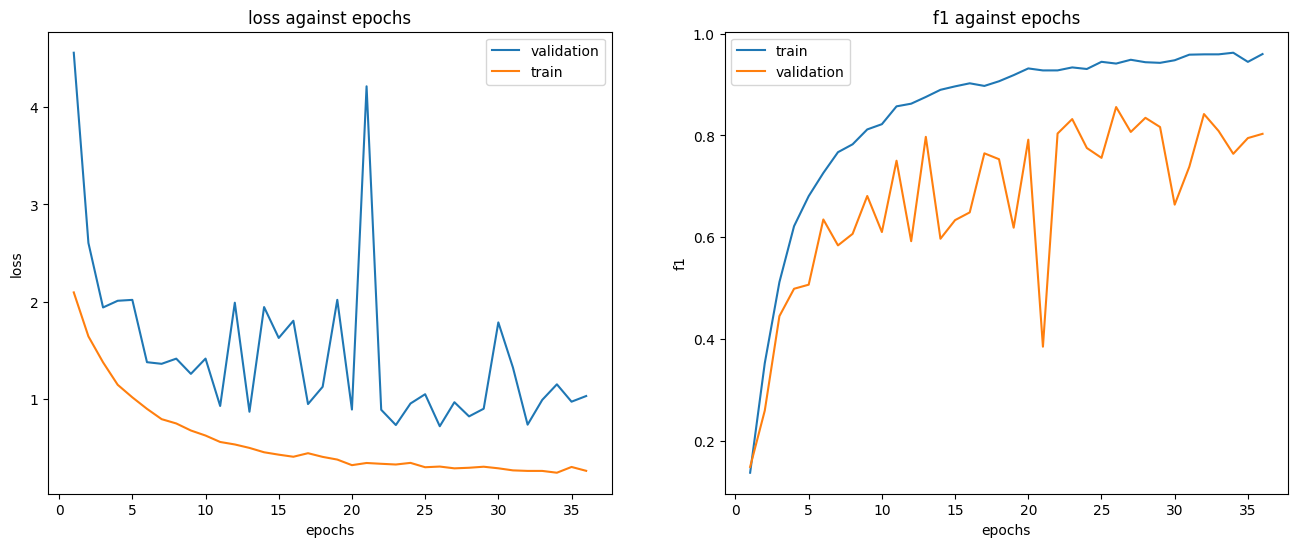

69/69 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       200
           1       0.89      0.85      0.87       200
           2       0.93      0.86      0.89       200
           3       0.99      0.65      0.79       200
           4       0.96      0.94      0.95       200
           5       0.63      0.88      0.74       200
           6       0.91      0.87      0.89       200
           7       0.92      0.82      0.87       200
           8       0.78      0.92      0.84       200
           9       0.96      0.88      0.92       200
          10       0.84      0.80      0.82       200

    accuracy                           0.85      2200
   macro avg       0.87      0.85      0.85      2200
weighted avg       0.87      0.85      0.85      2200



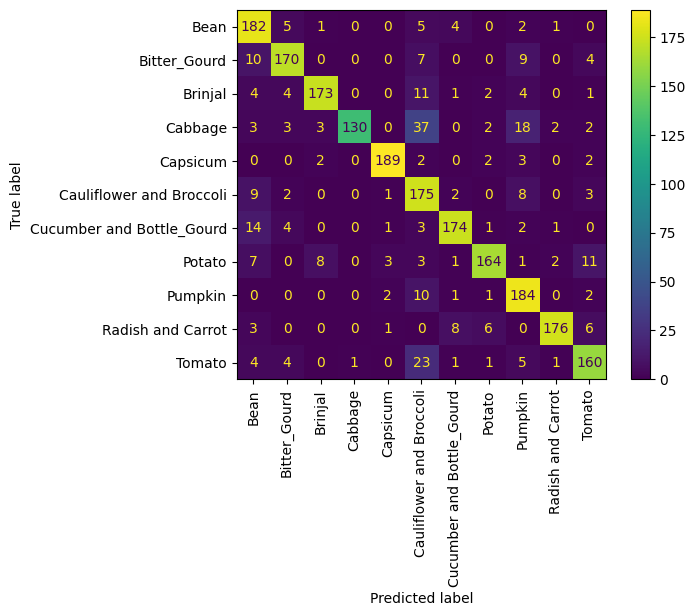

In [29]:
# 23x23
params = successful_params_23[best_index_23] 
print(f'Testing {successful_params_23[best_index_23]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_23_final.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params , lr=1e-3)
results = model.fit(X_train_23_augmented, y_train_23_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_23, y_validation_23),
                    class_weight=class_weights_dict_23,
                    verbose=1
                    )

# plotting
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(results.history['loss']) + 1)

# loss
ax[0].plot(epochs , results.history['val_loss'], label='validation')
ax[0].plot(epochs , results.history['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , results.history['f1_score'] , label='train')
ax[1].plot(epochs , results.history['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()


# predict
y_pred = model.predict(X_test_23)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_23, axis=1)
print(classification_report(y_test_labels , y_pred))

cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_23.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

Testing {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.3, 'kernel_regularization': 1e-06, 'kernel_size': (3, 3), 'm': 4, 'n': 3, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
Epoch 1/50
128/128 [==============================] - 21s 150ms/step - loss: 2.0718 - precision: 0.6538 - recall: 0.1938 - accuracy: 0.3995 - val_loss: 5.9614 - val_precision: 0.0805 - val_recall: 0.0805 - val_accuracy: 0.0805 - f1_score: 0.2990 - val_f1_score: 0.0805
Epoch 2/50
128/128 [==============================] - 18s 142ms/step - loss: 1.4800 - precision: 0.7516 - recall: 0.4458 - accuracy: 0.5950 - val_loss: 4.5116 - val_precision: 0.1229 - val_recall: 0.0199 - val_accuracy: 0.0870 - f1_score: 0.5596 - val_f1_score: 0.0342
Epoch 3/50
128/128 [==============================] - 18s 143ms/step - loss: 1.2616 - precision: 0.7975 - recall: 0.5666 - accuracy: 0.6831 - val_loss: 3.8732 - val_precision: 0.0853 - val_recall: 0.0800 - val_accuracy: 0.0883 - f

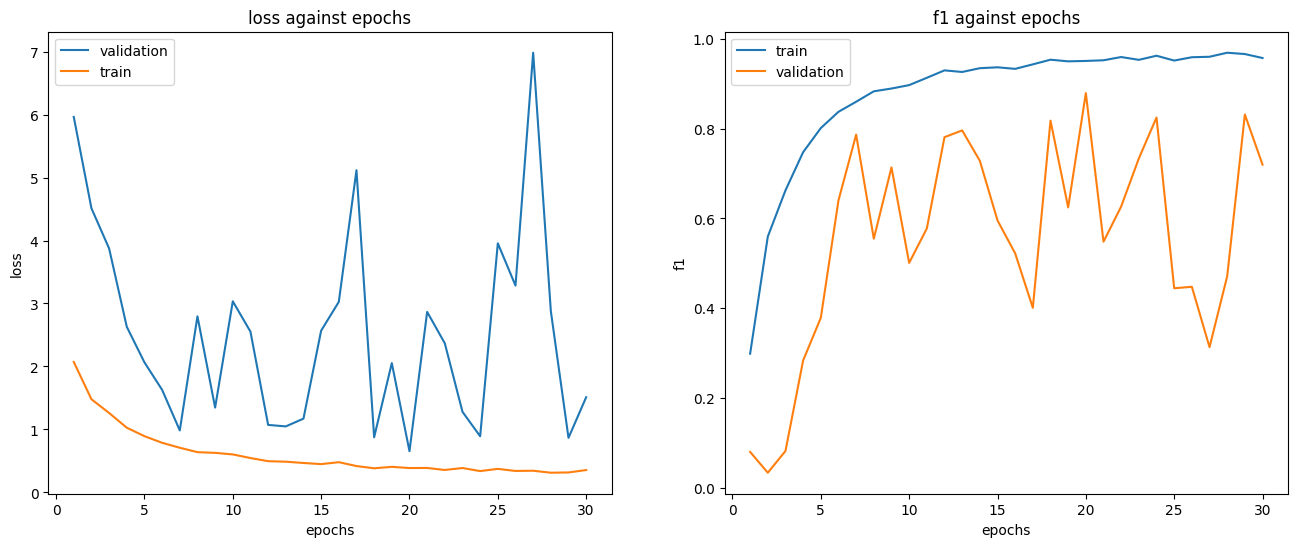

68/68 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       200
           1       1.00      0.67      0.80       200
           2       0.99      0.88      0.93       200
           3       0.90      0.87      0.88       200
           4       0.92      0.95      0.94       190
           5       0.82      0.94      0.88       198
           6       0.71      0.95      0.82       200
           7       0.99      0.59      0.74       175
           8       0.96      0.89      0.92       199
           9       0.89      0.88      0.88       200
          10       0.97      0.90      0.94       200

    accuracy                           0.87      2162
   macro avg       0.89      0.87      0.87      2162
weighted avg       0.89      0.87      0.87      2162



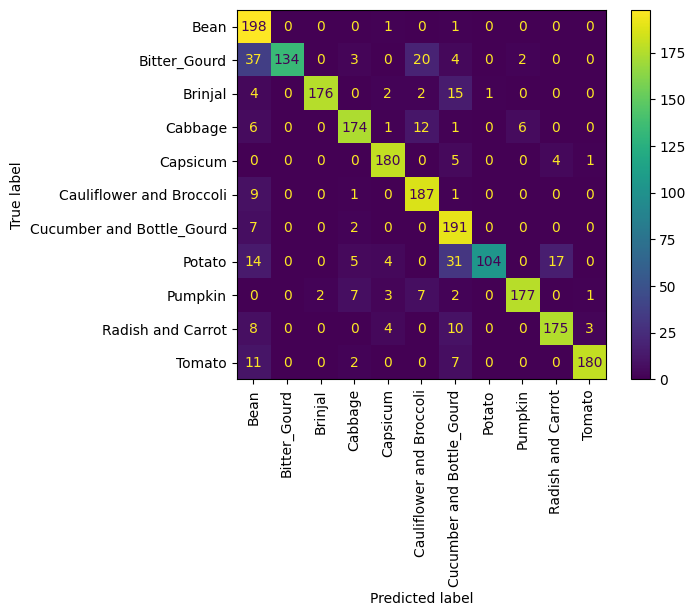

In [35]:
# 101x101
params = successful_params_101[best_index_101] 
print(f'Testing {successful_params_101[best_index_101]}')
model_params = {k:v for k , v in params.items() if k != 'batch_size'}
# callbacks
early_stopper = EarlyStopping(patience=10 , monitor='val_f1_score', restore_best_weights=True, mode='max')
model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_101_final.h5'),
                                    monitor='val_f1_score',
                                    save_best_only=True,
                                    save_weight_only=True,                                    
                                    mode='max'
                                   )
# fitting
model = create_model(**model_params , lr=1e-3)
results = model.fit(X_train_101_augmented, y_train_101_augmented,
                    epochs=50,
                    batch_size=params['batch_size'],
                    callbacks=[F1ScoreCallback() , early_stopper , model_checkpoint],
                    validation_data = (X_validation_101, y_validation_101),
                    class_weight=class_weights_dict_101,
                    verbose=1
                    )

# plotting
fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6))
epochs = range(1, len(results.history['loss']) + 1)

# loss
ax[0].plot(epochs , results.history['val_loss'], label='validation')
ax[0].plot(epochs , results.history['loss'] , label='train')
ax[0].legend()
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].set_title('loss against epochs')

# acc
ax[1].plot(epochs , results.history['f1_score'] , label='train')
ax[1].plot(epochs , results.history['val_f1_score'], label='validation')
ax[1].legend()
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('f1')
ax[1].set_title('f1 against epochs')
plt.show()


# predict
y_pred = model.predict(X_test_101)
y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

## results
y_test_labels = np.argmax(y_test_101, axis=1)
print(classification_report(y_test_labels , y_pred))

cm = confusion_matrix(y_test_labels , y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data_101.columns[1:])
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [34]:
gc.collect()

0